# Лабораторная работа №2 по глубокому обучению
## Устинов Александр, 3824М1ПМвм

## **Постановка задачи**

Требуется разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных CIFAR-10 с использованием фреймворка PyTorch:
1. Загрузить набор данных CIFAR-10 и выполнить предобработку данных, если это необходимо.
2. Реализовать сверточную нейронную сеть с использованием фреймворка PyTorch.
3. Выбрать подходящую функцию потерь и настроить гиперпараметры обучения.
4. Обучить реализованную нейронную сеть и провести оценку качества её работы.



## **Архитектура ResNet**

Для решения задачи классификации изображений будем использовать глубокую свёрточную нейронную сеть архитектуры ResNet. Особенностью ResNet является использование *остаточных блоков*, в которых используются *остаточные связи* (residual connections, skip-connections). Остаточный блок получается из последовательности обычных слоёв (свёрточных, нормализации) добавлением остаточной связи, за счёт этого при входе $x$, если выход набора обычных слоёв есть $F(x)$, выходом остаточного блока будет $F(x) + x$.

Остаточные связи решают проблему "исчезающего градиента" в глубоких сетях. При обучении обычной сети, если градиенты по модулю меньше 1, градиенты весов могут экспоненциально убывать при движении от конечных слоёв к начальным. В результате этого при большом числе слоёв веса, близкие к входному слою, обновляются медленно или не обновляются вовсе. Добавление остаточных связей позволяет избавиться от экспоненциального затухания, обеспечивает более стабильное обучение и лучший результат.



Существует несколько моделей архитектуры ResNet, отличающихся количеством слоёв и самими слоями. В данной работе будем использовать ResNet-18, более простую в сравнении с ResNet-34 и более глубокими моделями.

## **Реализация ResNet-18 на Python**

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn

Ниже приведена реализация ResNet-18 в виде класса `ResNet18`.

Особенностями реализации являются:

- Применение для начальной инициализации свёрточных и линейных слоёв генератора весов `kaiming_normal_`, использующего нормальное распределение с нулевым матожиданием и дисперсией, обратно пропорциональной корню из входного размера слоя;
- Использование dropout-слоёв на входе свёрточных и линейных слоёв для борьбы с переобучением.

In [3]:
# Sequence of convolutions, batch normalization and (optionally) ReLU
def convSequence(in_channels, out_channels, relu=False):
    layers = [
        nn.Dropout(0.2),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
    ]
    if relu: layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

def downsampleSequence(kernel_count):
    return nn.Sequential(
        convSequence(kernel_count // 2, kernel_count, relu=True),
        nn.MaxPool2d(2),
    )

# Sequence of residual blocks with downsampling in the end
class ResDownsampleSequence(nn.Module):
    def __init__(self, kernel_count):
        super().__init__()
        # downsampling and convolution layer
        self.seq_pool = nn.Sequential(
            downsampleSequence(kernel_count),
            convSequence(kernel_count, kernel_count),
        )
        # downsampling in skip connection
        self.skip_pool = nn.Sequential(
            convSequence(kernel_count // 2, kernel_count),
            nn.MaxPool2d(2),
        )
        self.seq = nn.Sequential(
            convSequence(kernel_count, kernel_count, relu=True),
            convSequence(kernel_count, kernel_count),
        )

    def forward(self, x):
        x = self.seq_pool(x) + self.skip_pool(x)
        x = self.seq(x) + x
        return x

class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional part of network
        # First 3 parts don't have downsampling
        self.conv1 = convSequence(3, 64)            # 32x32x64
        self.conv2 = nn.Sequential(
            convSequence(64, 64, relu=True),        # 32x32x64
            convSequence(64, 64),                   # 32x32x64
        )
        self.conv3 = nn.Sequential(
            convSequence(64, 64, relu=True),        # 32x32x64
            convSequence(64, 64),                   # 32x32x64
        )
        # The rest is with downsampling and increasing number of channels
        self.conv_downsample = nn.Sequential(
            ResDownsampleSequence(128),             # 16x16x128
            ResDownsampleSequence(256),             # 8x8x256
            ResDownsampleSequence(512),             # 4x4x512
        )

        # Classsification part of network (flattening + linear layer + softmax)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)), # 1x1x512
            nn.Flatten(),                # 512
            nn.Dropout(0.5),             # 512
            nn.Linear(512, 10),          # 10
        )
        # Random weight initialization
        self.apply(self.initializeWeightsKaiming)

    def initializeWeightsKaiming(self, m):
        # Initialize only conv and linear layers
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x) + x
        x = self.conv3(x) + x
        x = self.conv_downsample(x)
        x = self.classifier(x)
        return x


Убедимся, что размерности карт признаков на каждом слое сети совпадают с ожидаемыми:

In [ ]:
from torchinfo import summary
model = ResNet18()
summary(model, input_size=(32, 3, 32, 32))

Layer (type:depth-idx)                             Output Shape              Param #
ResNet18                                           [32, 10]                  --
├─Sequential: 1-1                                  [32, 64, 32, 32]          --
│    └─Dropout: 2-1                                [32, 3, 32, 32]           --
│    └─Conv2d: 2-2                                 [32, 64, 32, 32]          1,792
│    └─BatchNorm2d: 2-3                            [32, 64, 32, 32]          128
├─Sequential: 1-2                                  [32, 64, 32, 32]          --
│    └─Sequential: 2-4                             [32, 64, 32, 32]          --
│    │    └─Dropout: 3-1                           [32, 64, 32, 32]          --
│    │    └─Conv2d: 3-2                            [32, 64, 32, 32]          36,928
│    │    └─BatchNorm2d: 3-3                       [32, 64, 32, 32]          128
│    │    └─ReLU: 3-4                              [32, 64, 32, 32]          --
│    └─Sequential: 2-5    

## **Набор данных и его предобработка**

Набор данных CIFAR-10 содержит 60000 цветных изображений размером 32x32. Изображения разделены на 10 классов, каждый из них содержит 6000 изображений.



Загрузим набор с помощью библиотеки `torchvision` в составе PyTorch. Функциональность библиотеки позволяет получить тренировочную и тестовую выборки в зависимости от значения параметра `Train`.

In [4]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

cifar10_train = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,
                                             download=True,
                                             transform=transforms.Compose([
                                                 # transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                             ]))
cifar10_test = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            download=True,
                                            transform=transforms.Compose([
                                                # transforms.Resize((224, 224)),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                            ]))
trainloader = torch.utils.data.DataLoader(cifar10_train,
                                          batch_size=512,
                                          shuffle=True,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(cifar10_test,
                                         batch_size=512,
                                         num_workers=2)

100%|██████████| 170M/170M [00:15<00:00, 11.4MB/s]


Отобразим размерность тензора набора изображений и метки:

In [5]:
images, labels = next(iter(trainloader))
print('Batch shape:', images.shape)
print('Labels:', labels)

Batch shape: torch.Size([512, 3, 32, 32])
Labels: tensor([8, 8, 0, 9, 1, 1, 5, 7, 6, 3, 6, 4, 0, 4, 6, 9, 9, 7, 3, 1, 4, 9, 0, 4,
        5, 7, 1, 5, 4, 7, 7, 6, 4, 3, 3, 7, 8, 7, 2, 1, 5, 4, 3, 6, 8, 6, 0, 5,
        4, 8, 5, 0, 4, 1, 2, 5, 1, 7, 9, 2, 6, 8, 8, 2, 0, 0, 7, 9, 2, 4, 6, 3,
        9, 9, 5, 0, 6, 4, 1, 3, 7, 7, 8, 7, 3, 5, 9, 2, 3, 3, 3, 7, 7, 9, 6, 1,
        4, 9, 2, 4, 8, 2, 7, 5, 7, 1, 2, 7, 6, 0, 8, 9, 1, 6, 7, 2, 5, 8, 4, 6,
        7, 7, 0, 3, 5, 4, 6, 3, 4, 2, 1, 1, 4, 6, 5, 5, 0, 1, 0, 7, 6, 2, 8, 5,
        1, 4, 1, 9, 9, 5, 1, 4, 5, 9, 9, 2, 0, 4, 8, 5, 7, 5, 5, 0, 9, 3, 4, 0,
        7, 8, 0, 6, 0, 1, 7, 4, 3, 5, 9, 6, 4, 1, 4, 4, 2, 4, 6, 7, 0, 7, 1, 1,
        3, 0, 8, 4, 8, 8, 1, 8, 7, 3, 5, 4, 4, 7, 1, 0, 5, 2, 3, 5, 6, 8, 6, 6,
        1, 4, 2, 4, 9, 1, 5, 2, 6, 0, 4, 4, 9, 0, 4, 0, 5, 3, 6, 3, 2, 8, 3, 0,
        2, 8, 6, 6, 6, 6, 4, 4, 7, 8, 8, 6, 8, 6, 4, 5, 3, 4, 2, 3, 4, 8, 0, 8,
        3, 6, 9, 1, 2, 6, 6, 7, 2, 5, 5, 4, 4, 3, 8, 7, 9, 2, 5, 9, 6,

## **Обучение сети**

In [7]:
import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Напишем функцию, которая будет осуществлять обучение сети. В течение эпохи будем вычислять средние значения функции потерь и точности на тренировочной выборке, по окончании эпохи будем вычислять те же значения для тестовой выборки.

Для улучшения качества обучения было решено использовать переменный learning rate, в частности, `CosineAnnealingLR`, обеспечивающий медленное убывание learning rate на начальных и конечных эпохах и быстрое убывание на промежуточных эпохах. Также для борьбы с переобучением и стабилизации обучения используется регуляризация функции потерь с помощью параметра `weight_decay`, вводящего в функцию потерь штраф, пропорциональный сумме квадратов весов модели.

In [8]:
def train(model, trainloader, testloader, epoch_count=20, learning_rate=1e-3):
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-4, T_max=epoch_count)

    epoches = []
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epoch_count):
        # Train for an epoch
        train_loss = .0
        test_loss = .0
        train_size = cifar10_train.data.shape[0]
        test_size = cifar10_test.data.shape[0]
        train_predict_cnt = 0
        test_predict_cnt = 0

        model.train()
        for x_batch, y_batch in tqdm.tqdm(trainloader, position=0, leave=True):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            loss = loss_function(logits, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += float(loss * x_batch.shape[0])
                y_predict = logits.argmax(axis=1)
                train_predict_cnt += (y_predict == y_batch).sum()

        # Evaluate score on test samples
        model.eval()
        batch_test_losses = []

        with torch.no_grad():
            for x_batch, y_batch in tqdm.tqdm(testloader, position=0, leave=True):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                logits = model(x_batch)
                batch_test_losses.append(loss_function(logits, y_batch))
                y_predict = logits.argmax(axis=1)
                test_predict_cnt += (y_predict == y_batch).sum()

            # Total loss is sum of scaled batch losses divided by train set size
            train_loss /= cifar10_train.data.shape[0]
            test_loss = torch.stack(batch_test_losses).float().mean().item()
            train_accuracy = float(train_predict_cnt / cifar10_train.data.shape[0])
            test_accuracy = float(test_predict_cnt / cifar10_test.data.shape[0])
            print('Epoch=', epoch + 1, '\n',
                  'learning rate=', lr_scheduler.get_last_lr()[0], '\n',
                  'train loss=', train_loss, '\n',
                  'train accuracy=', train_accuracy, '\n',
                  'test loss=', test_loss, '\n',
                  'test accuracy=', test_accuracy, '\n', sep='')

            epoches.append(epoch)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
        lr_scheduler.step()

    return epoches, train_losses, train_accuracies, test_losses, test_accuracies
    # plt.plot(epoches, train_losses, label='Train loss')
    # plt.plot(epoches, test_losses, label='Test loss')
    # plt.legend()
    # plt.show()




Создадим модель и запустим обучение. Будем использовать 100 эпох и learning rate, равный $3\cdot 10^{-3}$.

In [9]:
model = ResNet18()
model = model.to(device)
epoch_count = 100
lr = 3e-3
epoches, train_losses, train_accuracies, test_losses, test_accuracies = train(model, trainloader, testloader, epoch_count, lr)

100%|██████████| 20/20 [00:03<00:00,  5.95it/s]


Epoch=1
learning rate=0.003
train loss=2.3626521508789065
train accuracy=0.2869199812412262
test loss=1.8031834363937378
test accuracy=0.3342999815940857



100%|██████████| 20/20 [00:03<00:00,  5.49it/s]


Epoch=2
learning rate=0.002999284512530311
train loss=1.4975555078125
train accuracy=0.450219988822937
test loss=1.678350806236267
test accuracy=0.42489999532699585



100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch=3
learning rate=0.0029971387562209937
train loss=1.2682436444091796
train accuracy=0.5403000116348267
test loss=1.6248130798339844
test accuracy=0.44179999828338623



100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Epoch=4
learning rate=0.002993564848674466
train loss=1.1212453546142578
train accuracy=0.5957399606704712
test loss=1.4252392053604126
test accuracy=0.5130000114440918



100%|██████████| 20/20 [00:03<00:00,  5.50it/s]


Epoch=5
learning rate=0.002988566316905993
train loss=0.9984657470703125
train accuracy=0.6457799673080444
test loss=1.428200602531433
test accuracy=0.5375999808311462



100%|██████████| 20/20 [00:03<00:00,  5.69it/s]


Epoch=6
learning rate=0.0029821480938629495
train loss=0.9095635412597656
train accuracy=0.6788600087165833
test loss=1.1453062295913696
test accuracy=0.6093999743461609



100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch=7
learning rate=0.0029743165135565986
train loss=0.8461515515136718
train accuracy=0.7012999653816223
test loss=1.1070823669433594
test accuracy=0.6355999708175659



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=8
learning rate=0.0029650793048111835
train loss=0.7969153585815429
train accuracy=0.7216599583625793
test loss=0.9114121794700623
test accuracy=0.6886000037193298



100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


Epoch=9
learning rate=0.0029544455836365145
train loss=0.7473679385375976
train accuracy=0.7389799952507019
test loss=1.015120506286621
test accuracy=0.6567999720573425



100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch=10
learning rate=0.002942425844231567
train loss=0.7065127188110352
train accuracy=0.7529000043869019
test loss=0.7990085482597351
test accuracy=0.727400004863739



100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Epoch=11
learning rate=0.002929031948627972
train loss=0.6740957159423828
train accuracy=0.7658799886703491
test loss=0.8581209182739258
test accuracy=0.7114999890327454



100%|██████████| 20/20 [00:03<00:00,  5.54it/s]


Epoch=12
learning rate=0.0029142771149836266
train loss=0.6331515643310547
train accuracy=0.7803199887275696
test loss=1.2557474374771118
test accuracy=0.632099986076355



100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch=13
learning rate=0.0028981759045379643
train loss=0.6090563555908203
train accuracy=0.7894399762153625
test loss=0.8146281242370605
test accuracy=0.736299991607666



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=14
learning rate=0.002880744207241772
train loss=0.5833354876708985
train accuracy=0.7978799939155579
test loss=0.6347751021385193
test accuracy=0.7838000059127808



100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch=15
learning rate=0.002861999226075728
train loss=0.5521077767944336
train accuracy=0.8082000017166138
test loss=0.7966578602790833
test accuracy=0.7408999800682068



100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch=16
learning rate=0.002841959460073133
train loss=0.5429031689453125
train accuracy=0.8133599758148193
test loss=0.6598209738731384
test accuracy=0.777999997138977



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=17
learning rate=0.0028206446860636015
train loss=0.5150634985351562
train accuracy=0.8215000033378601
test loss=0.6597695350646973
test accuracy=0.7833999991416931



100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


Epoch=18
learning rate=0.0027980759391557177
train loss=0.49625698822021486
train accuracy=0.8269000053405762
test loss=0.6088130474090576
test accuracy=0.7943999767303467



100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


Epoch=19
learning rate=0.0027742754919779216
train loss=0.4842878875732422
train accuracy=0.8309800028800964
test loss=0.6159600615501404
test accuracy=0.7883999943733215



100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Epoch=20
learning rate=0.0027492668326981142
train loss=0.46546901000976565
train accuracy=0.8379600048065186
test loss=0.5745784044265747
test accuracy=0.8082999587059021



100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


Epoch=21
learning rate=0.0027230746418436735
train loss=0.45479228424072266
train accuracy=0.8403399586677551
test loss=0.7221227884292603
test accuracy=0.7626999616622925



100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch=22
learning rate=0.0026957247679447504
train loss=0.43242100494384766
train accuracy=0.8500799536705017
test loss=0.7081231474876404
test accuracy=0.7744999527931213



100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Epoch=23
learning rate=0.002667244202024894
train loss=0.4224618539428711
train accuracy=0.852620005607605
test loss=0.5885604619979858
test accuracy=0.8029999732971191



100%|██████████| 20/20 [00:03<00:00,  5.71it/s]


Epoch=24
learning rate=0.002637661050964166
train loss=0.40724054901123047
train accuracy=0.8596799969673157
test loss=0.5802470445632935
test accuracy=0.8068999648094177



100%|██████████| 20/20 [00:03<00:00,  5.71it/s]


Epoch=25
learning rate=0.0026070045097610463
train loss=0.4108731594848633
train accuracy=0.8577799797058105
test loss=0.5881704688072205
test accuracy=0.8075999617576599



100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch=26
learning rate=0.0025753048327204933
train loss=0.3859305532836914
train accuracy=0.8672199845314026
test loss=0.6361052393913269
test accuracy=0.7853999733924866



100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Epoch=27
learning rate=0.002542593303596598
train loss=0.379749001159668
train accuracy=0.8686400055885315
test loss=0.5404612421989441
test accuracy=0.8172999620437622



100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


Epoch=28
learning rate=0.002508902204719295
train loss=0.37013626647949216
train accuracy=0.8714199662208557
test loss=0.5618303418159485
test accuracy=0.8154999613761902



100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch=29
learning rate=0.0024742647851355997
train loss=0.3578188195800781
train accuracy=0.8764199614524841
test loss=0.5396420359611511
test accuracy=0.8211999535560608



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=30
learning rate=0.0024387152277968154
train loss=0.34919303939819335
train accuracy=0.8784999847412109
test loss=0.5750510692596436
test accuracy=0.8113999962806702



100%|██████████| 20/20 [00:03<00:00,  5.46it/s]


Epoch=31
learning rate=0.0024022886158240856
train loss=0.3394253578186035
train accuracy=0.882159948348999
test loss=0.5594741702079773
test accuracy=0.8199999928474426



100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Epoch=32
learning rate=0.0023650208978855886
train loss=0.33642731689453126
train accuracy=0.8821399807929993
test loss=0.5330198407173157
test accuracy=0.8274999856948853



100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch=33
learning rate=0.002326948852719544
train loss=0.3203606568908691
train accuracy=0.8901199698448181
test loss=0.536854088306427
test accuracy=0.8234999775886536



100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch=34
learning rate=0.002288110052838037
train loss=0.3137216262817383
train accuracy=0.8919199705123901
test loss=0.6006718873977661
test accuracy=0.809499979019165



100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Epoch=35
learning rate=0.002248542827447486
train loss=0.3128628549194336
train accuracy=0.8902199864387512
test loss=0.5675942301750183
test accuracy=0.8185999989509583



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=36
learning rate=0.002208286224622342
train loss=0.2933389321899414
train accuracy=0.8962000012397766
test loss=0.534584641456604
test accuracy=0.8265999555587769



100%|██████████| 20/20 [00:03<00:00,  5.21it/s]


Epoch=37
learning rate=0.0021673799727693543
train loss=0.28752206604003905
train accuracy=0.8999599814414978
test loss=0.5705376267433167
test accuracy=0.8271999955177307



100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Epoch=38
learning rate=0.002125864441420431
train loss=0.28516033630371096
train accuracy=0.9013399481773376
test loss=0.550310492515564
test accuracy=0.8223999738693237



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=39
learning rate=0.0020837806013927827
train loss=0.2749409605407715
train accuracy=0.9043799638748169
test loss=0.5310737490653992
test accuracy=0.8324999809265137



100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


Epoch=40
learning rate=0.0020411699843556723
train loss=0.26692222473144533
train accuracy=0.9055999517440796
test loss=0.5316740274429321
test accuracy=0.8233000040054321



100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Epoch=41
learning rate=0.001998074641843673
train loss=0.2566280969238281
train accuracy=0.9102399945259094
test loss=0.5232778787612915
test accuracy=0.842799961566925



100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch=42
learning rate=0.0019545371037568817
train loss=0.24706471267700195
train accuracy=0.913100004196167
test loss=0.47153550386428833
test accuracy=0.8465999960899353



100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


Epoch=43
learning rate=0.0019106003363890383
train loss=0.23771053955078125
train accuracy=0.9167199730873108
test loss=0.44843941926956177
test accuracy=0.8534999489784241



100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Epoch=44
learning rate=0.001866307700024986
train loss=0.2393707536315918
train accuracy=0.91621994972229
test loss=0.47758060693740845
test accuracy=0.8486999869346619



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=45
learning rate=0.0018217029061493003
train loss=0.2361623831176758
train accuracy=0.916979968547821
test loss=0.44420433044433594
test accuracy=0.8585999608039856



100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch=46
learning rate=0.0017768299743083343
train loss=0.21680972961425782
train accuracy=0.9250999689102173
test loss=0.4511661231517792
test accuracy=0.8650999665260315



100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch=47
learning rate=0.001731733188668241
train loss=0.21633736740112305
train accuracy=0.9233599901199341
test loss=0.41541028022766113
test accuracy=0.8660999536514282



100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch=48
learning rate=0.0016864570543118453
train loss=0.20559100189208984
train accuracy=0.9284999966621399
test loss=0.4318167269229889
test accuracy=0.8654999732971191



100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Epoch=49
learning rate=0.001641046253317504
train loss=0.19778537506103516
train accuracy=0.9315799474716187
test loss=0.44468769431114197
test accuracy=0.8610999584197998



100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch=50
learning rate=0.0015955456006632857
train loss=0.18673390701293946
train accuracy=0.9337799549102783
test loss=0.4353099763393402
test accuracy=0.8661999702453613



100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch=51
learning rate=0.0015499999999999997
train loss=0.18489057083129884
train accuracy=0.9360799789428711
test loss=0.42945393919944763
test accuracy=0.8671999573707581



100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


Epoch=52
learning rate=0.0015044543993367138
train loss=0.18093964340209961
train accuracy=0.9376599788665771
test loss=0.46245598793029785
test accuracy=0.8619999885559082



100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch=53
learning rate=0.0014589537466824954
train loss=0.1719213607788086
train accuracy=0.9407999515533447
test loss=0.42614561319351196
test accuracy=0.8666999936103821



100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Epoch=54
learning rate=0.001413542945688154
train loss=0.15357848197937013
train accuracy=0.946459949016571
test loss=0.4978523254394531
test accuracy=0.8503999710083008



100%|██████████| 20/20 [00:03<00:00,  5.72it/s]


Epoch=55
learning rate=0.0013682668113317586
train loss=0.15476759826660155
train accuracy=0.9458199739456177
test loss=0.47844791412353516
test accuracy=0.8637999892234802



100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch=56
learning rate=0.001323170025691665
train loss=0.1553587247467041
train accuracy=0.9458199739456177
test loss=0.42173686623573303
test accuracy=0.8721999526023865



100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch=57
learning rate=0.0012782970938506992
train loss=0.1379261004638672
train accuracy=0.9529599547386169
test loss=0.4930751919746399
test accuracy=0.8610999584197998



100%|██████████| 20/20 [00:03<00:00,  5.57it/s]


Epoch=58
learning rate=0.0012336922999750136
train loss=0.13585447677612306
train accuracy=0.9529199600219727
test loss=0.4348311424255371
test accuracy=0.873699963092804



100%|██████████| 20/20 [00:03<00:00,  5.69it/s]


Epoch=59
learning rate=0.0011893996636109603
train loss=0.1304497721862793
train accuracy=0.9537799954414368
test loss=0.4628628194332123
test accuracy=0.8714999556541443



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=60
learning rate=0.0011454628962431176
train loss=0.12440750511169434
train accuracy=0.9563799500465393
test loss=0.44396743178367615
test accuracy=0.8702999949455261



100%|██████████| 20/20 [00:03<00:00,  5.55it/s]


Epoch=61
learning rate=0.0011019253581563266
train loss=0.11112976593017578
train accuracy=0.960599958896637
test loss=0.5161698460578918
test accuracy=0.8583999872207642



100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


Epoch=62
learning rate=0.0010588300156443274
train loss=0.11498179176330567
train accuracy=0.9607999920845032
test loss=0.4755983352661133
test accuracy=0.8702999949455261



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=63
learning rate=0.0010162193986072172
train loss=0.1101543995666504
train accuracy=0.9617799520492554
test loss=0.4574470520019531
test accuracy=0.8718999624252319



100%|██████████| 20/20 [00:03<00:00,  5.54it/s]


Epoch=64
learning rate=0.0009741355585795677
train loss=0.09997141017913819
train accuracy=0.9659599661827087
test loss=0.47134295105934143
test accuracy=0.8743000030517578



100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch=65
learning rate=0.0009326200272306444
train loss=0.09442985954284668
train accuracy=0.966759979724884
test loss=0.4370444715023041
test accuracy=0.8768999576568604



100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch=66
learning rate=0.000891713775377657
train loss=0.08962682991027832
train accuracy=0.9684199690818787
test loss=0.43205252289772034
test accuracy=0.8823999762535095



100%|██████████| 20/20 [00:03<00:00,  5.56it/s]


Epoch=67
learning rate=0.0008514571725525124
train loss=0.08073313659667969
train accuracy=0.9721599817276001
test loss=0.42377957701683044
test accuracy=0.8847999572753906



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=68
learning rate=0.0008118899471619614
train loss=0.07958609809875489
train accuracy=0.972279965877533
test loss=0.44328323006629944
test accuracy=0.8793999552726746



100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch=69
learning rate=0.0007730511472804544
train loss=0.07076095935821533
train accuracy=0.975820004940033
test loss=0.4340403079986572
test accuracy=0.8809999823570251



100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


Epoch=70
learning rate=0.0007349791021144104
train loss=0.07255392986297607
train accuracy=0.9758999943733215
test loss=0.43743792176246643
test accuracy=0.8841999769210815



100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch=71
learning rate=0.0006977113841759141
train loss=0.06293021236419678
train accuracy=0.9787399768829346
test loss=0.43801361322402954
test accuracy=0.8894000053405762



100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Epoch=72
learning rate=0.0006612847722031839
train loss=0.06267126472473145
train accuracy=0.9788199663162231
test loss=0.4706239700317383
test accuracy=0.8816999793052673



100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


Epoch=73
learning rate=0.0006257352148643999
train loss=0.05692073802947998
train accuracy=0.9803799986839294
test loss=0.42641481757164
test accuracy=0.8854999542236328



100%|██████████| 20/20 [00:03<00:00,  5.72it/s]


Epoch=74
learning rate=0.0005910977952807051
train loss=0.048421002101898196
train accuracy=0.9834599494934082
test loss=0.41239118576049805
test accuracy=0.8924999833106995



100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Epoch=75
learning rate=0.0005574066964034014
train loss=0.05019666213989258
train accuracy=0.9827799797058105
test loss=0.45407840609550476
test accuracy=0.8854999542236328



100%|██████████| 20/20 [00:03<00:00,  5.54it/s]


Epoch=76
learning rate=0.0005246951672795063
train loss=0.044845267219543454
train accuracy=0.9840999841690063
test loss=0.4140258729457855
test accuracy=0.8916999697685242



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=77
learning rate=0.0004929954902389537
train loss=0.04319849842071533
train accuracy=0.9853599667549133
test loss=0.41181403398513794
test accuracy=0.8947999477386475



100%|██████████| 20/20 [00:03<00:00,  5.68it/s]


Epoch=78
learning rate=0.00046233894903583366
train loss=0.03914846668243408
train accuracy=0.9869199991226196
test loss=0.4084174335002899
test accuracy=0.8965999484062195



100%|██████████| 20/20 [00:03<00:00,  5.30it/s]


Epoch=79
learning rate=0.0004327557979751058
train loss=0.037498234405517576
train accuracy=0.9875399470329285
test loss=0.42551594972610474
test accuracy=0.8946999907493591



100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Epoch=80
learning rate=0.000404275232055249
train loss=0.03564619560241699
train accuracy=0.988319993019104
test loss=0.44180700182914734
test accuracy=0.8917999863624573



100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Epoch=81
learning rate=0.00037692535815632644
train loss=0.03013655343055725
train accuracy=0.9897799491882324
test loss=0.4263117015361786
test accuracy=0.8970999717712402



100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


Epoch=82
learning rate=0.0003507331673018856
train loss=0.030170426149368285
train accuracy=0.9900999665260315
test loss=0.4285458028316498
test accuracy=0.8953999876976013



100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch=83
learning rate=0.00032572450802207856
train loss=0.026366066608428954
train accuracy=0.9912599921226501
test loss=0.4242008328437805
test accuracy=0.8981999754905701



100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch=84
learning rate=0.00030192406084428167
train loss=0.025039801292419433
train accuracy=0.9914599657058716
test loss=0.41950106620788574
test accuracy=0.8976999521255493



100%|██████████| 20/20 [00:03<00:00,  5.44it/s]


Epoch=85
learning rate=0.00027935531393639794
train loss=0.024096875314712524
train accuracy=0.9921199679374695
test loss=0.44836854934692383
test accuracy=0.8955999612808228



100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch=86
learning rate=0.00025804053992686685
train loss=0.02117005702018738
train accuracy=0.9931399822235107
test loss=0.4190312325954437
test accuracy=0.8989999890327454



100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Epoch=87
learning rate=0.0002380007739242721
train loss=0.018967406911849977
train accuracy=0.993619978427887
test loss=0.4153554141521454
test accuracy=0.8996999859809875



100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Epoch=88
learning rate=0.00021925579275822784
train loss=0.018514480543136598
train accuracy=0.9941200017929077
test loss=0.4438590705394745
test accuracy=0.8938999772071838



100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch=89
learning rate=0.00020182409546203568
train loss=0.017252724804878234
train accuracy=0.9942799806594849
test loss=0.4282112121582031
test accuracy=0.9003999829292297



100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Epoch=90
learning rate=0.0001857228850163732
train loss=0.016147295274734498
train accuracy=0.9949399828910828
test loss=0.42699676752090454
test accuracy=0.8988999724388123



100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Epoch=91
learning rate=0.00017096805137202748
train loss=0.01651136751651764
train accuracy=0.9949199557304382
test loss=0.4338037669658661
test accuracy=0.9003999829292297



100%|██████████| 20/20 [00:03<00:00,  5.72it/s]


Epoch=92
learning rate=0.0001575741557684328
train loss=0.014365865347385407
train accuracy=0.9955599904060364
test loss=0.43751946091651917
test accuracy=0.8991000056266785



100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch=93
learning rate=0.00014555441636348516
train loss=0.01370216655254364
train accuracy=0.9955599904060364
test loss=0.4432934820652008
test accuracy=0.901199996471405



100%|██████████| 20/20 [00:03<00:00,  5.52it/s]


Epoch=94
learning rate=0.00013492069518881641
train loss=0.013378405618667603
train accuracy=0.9954999685287476
test loss=0.42964401841163635
test accuracy=0.8998000025749207



100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch=95
learning rate=0.00012568348644340137
train loss=0.011908983490467071
train accuracy=0.9963199496269226
test loss=0.43351513147354126
test accuracy=0.899899959564209



100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch=96
learning rate=0.00011785190613705041
train loss=0.01134620996952057
train accuracy=0.9964399933815002
test loss=0.43377190828323364
test accuracy=0.8998000025749207



100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


Epoch=97
learning rate=0.00011143368309400725
train loss=0.011234184641838073
train accuracy=0.9965599775314331
test loss=0.42160874605178833
test accuracy=0.9010999798774719



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=98
learning rate=0.00010643515132553402
train loss=0.010337340633869171
train accuracy=0.9970799684524536
test loss=0.4327877163887024
test accuracy=0.901699960231781



100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch=99
learning rate=0.00010286124377900625
train loss=0.010620105508565902
train accuracy=0.9969199895858765
test loss=0.4278714656829834
test accuracy=0.9018999934196472



100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Epoch=100
learning rate=0.00010071548746968918
train loss=0.009600893957614898
train accuracy=0.9971799850463867
test loss=0.4261954426765442
test accuracy=0.9021999835968018



Графики зависимости функции потерь и точности от эпохи для тренировочной и тестовой выборок:

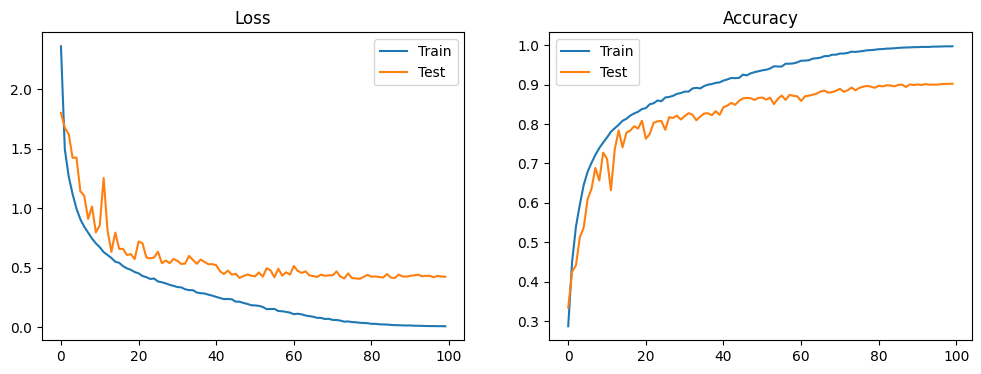

In [10]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].set_title('Loss')
axes[0].plot(epoches, train_losses, label='Train')
axes[0].plot(epoches, test_losses, label='Test')
axes[0].legend()

axes[1].set_title('Accuracy')
axes[1].plot(epoches, train_accuracies, label='Train')
axes[1].plot(epoches, test_accuracies, label='Test')
axes[1].legend()

plt.show()

Видно, что на тренировочной выборке функция убывает, а точность возрастает на протяжении всего обучения. Для тестовой же выборки функция потерь выходит на плато примерно на 50 эпохе, хотя точность при этом продолжает медленно возрастать.

Сохраним веса модели в файл и вычислим итоговую точность сети на тестовой выборке:

In [ ]:
torch.save(model.state_dict(), './resnet18_weights')

In [11]:
def evaluate(model, testloader):
    batch_test_losses = []
    test_predict_cnt = 0
    loss_function = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm.tqdm(testloader, position=0, leave=True):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            batch_test_losses.append(loss_function(logits, y_batch))
            y_predict = logits.argmax(axis=1)
            test_predict_cnt += (y_predict == y_batch).sum()

        # Total loss is sum of scaled batch losses divided by train set size
        test_loss = torch.stack(batch_test_losses).float().mean().item()
        test_accuracy = float(test_predict_cnt / cifar10_test.data.shape[0])
        print('test loss=', test_loss, '\n',
              'test accuracy=', test_accuracy, '\n', sep='')

In [12]:
evaluate(model, testloader)

100%|██████████| 20/20 [00:04<00:00,  4.40it/s]

test loss=0.4261954426765442
test accuracy=0.9021999835968018



Как видно, точность на тестовой выборке составила 90.2%.